In [823]:
import numpy as np
import pandas as pd
pd.options.display.max_rows=10
import matplotlib.pyplot as plt
import matplotlib
import iso3166

In [12]:
filename="COVID-19-geographic-disbtribution-worldwide-2020-03-24.xlsx"
URL_base="https://www.ecdc.europa.eu/sites/default/files/documents/"
URL=URL_base+filename

In [4]:
#!curl $URL -o filename --noproxy europa.eu
!wget $URL -nc --no-proxy

--2020-03-24 12:08:13--  https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-24.xlsx
Resolving www.ecdc.europa.eu (www.ecdc.europa.eu)... 13.249.71.97, 13.249.71.10, 13.249.71.31, ...
Connecting to www.ecdc.europa.eu (www.ecdc.europa.eu)|13.249.71.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253573 (248K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘COVID-19-geographic-disbtribution-worldwide-2020-03-24.xlsx’

COVID-19-geographic 100%[===================>] 247.63K   568KB/s    in 0.4s    

2020-03-24 12:08:33 (568 KB/s) - ‘COVID-19-geographic-disbtribution-worldwide-2020-03-24.xlsx’ saved [253573/253573]



In [853]:
ecdc=pd.read_excel(filename)
cases=ecdc.pivot(index="DateRep", columns="GeoId", values="Cases").fillna(0)
Ncases=cases.cumsum()
deaths=ecdc.pivot(index="DateRep", columns="GeoId", values="Deaths").fillna(0)
Ndeaths=deaths.cumsum()
Tdouble=np.log(2)/np.log(1+cases/Ncases.replace({0:np.nan}).shift(1)).replace({0:np.nan})
Tdouble_smooth=Tdouble.rolling(5).mean()
Countries=ecdc[['GeoId', "Countries and territories"]].drop_duplicates().set_index("GeoId").rename(columns={"Countries and territories":"Country"})
# Countries=Countries.Country.str.replace('_',' ').str.replace('United States of America','USA').str.replace('United Kingdom','UK')


In [979]:
try:
    Population=pd.read_csv('Population.csv').set_index('GeoId')
except IOError:
    print('Population.csv not found')
    !wget "https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv" -nc --no-proxy
    wpp=pd.read_csv("WPP2019_TotalPopulationBySex.csv")
    wpp.set_index('LocID', inplace=True)
    wpp=wpp.loc[(wpp.Time==2020) & (wpp.Variant=='Medium')]

    Population=pd.DataFrame({'GeoId':[], 'Population':[]})
    for GeoId in Countries.index.drop_duplicates():
        if not np.isreal(GeoId) and len(GeoId)==2 and GeoId !='GG' and GeoId !='JE' and GeoId !='XK' and GeoId !='AN' and GeoId !='UK':
            LocID=np.int(iso3166.countries_by_alpha2[GeoId].numeric)
            pop=wpp.loc[LocID].PopTotal
            Population=Population.append(pd.DataFrame({'GeoId':[GeoId], 'Population':[pop]}))

    Population=Population.append(pd.DataFrame({'GeoId':['GG'], 'Population':[66.697]}))
    Population=Population.append(pd.DataFrame({'GeoId':['JE'], 'Population':[97.857]}))
    Population=Population.append(pd.DataFrame({'GeoId':['XK'], 'Population':[1831]}))
    Population=Population.append(pd.DataFrame({'GeoId':['AN'], 'Population':[227.049]}))
    Population=Population.append(pd.DataFrame({'GeoId':['UK'], 'Population':[67886]}))
#     Population=Population.append(pd.DataFrame({'GeoId':[np.NaN], 'Population':[np.NaN]}))
    Population=Population.append(pd.DataFrame({'GeoId':['JPG11668'], 'Population':[2000]}))
    Population.set_index('GeoId', inplace=True)
    Population/=1000
    Population.to_csv('Population.csv')
Population=Population.iloc[:,0] # Convert from DataFrame to Series, to be able to divide all rows with it!

In [1069]:
Hbeds=pd.Series({'CN':6250000,'US':924107,'KR':630000,'DE':661448,'ES':138511,'FR':399865,'IT':192548,'NL':56886,'UK':167589})

In [1083]:
Interest=['DE', 'NL', 'IT', 'FR', 'ES', 'UK', 'US', 'CN', 'KR']
# Interest=['DE', 'NL', 'IT', 'FR', 'UK', 'US']
#Interest=['DE', 'NL', 'IT', 'US']
startdate=pd.Timestamp("2020-02-21")

In [1084]:
Ncase100=pd.DataFrame({'days':[]}).set_index('days')
for GeoId in Ncases:
    temp=Ncases[GeoId].values[Ncases[GeoId].values>100]
    temp=pd.DataFrame({"days": np.arange(len(temp)), GeoId: temp}).set_index('days')
    Ncase100=Ncase100.join(temp, how='outer')

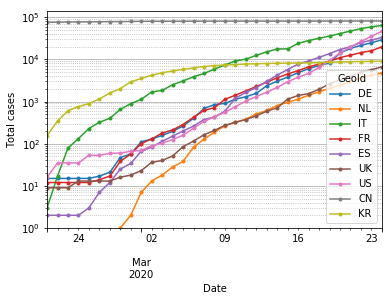

In [1085]:
p=Ncases[Interest].plot(logy=True, marker=".")
p.set_ylim(1,)
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("Total cases")
p.grid('on', which='major', axis='y')
p.grid('on', which='minor', axis='y', linestyle='dotted')

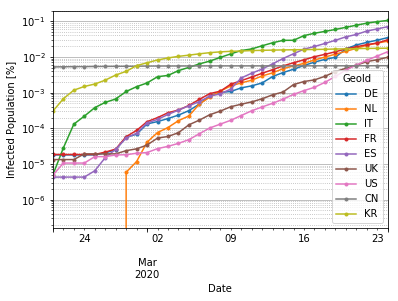

In [1086]:
Rinf=Ncases[Interest]/(Population[Interest]*1e6/100)
p=Rinf.plot(logy=True, marker=".")
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("Infected Population [%]")
p.grid('on', which='major', axis='y')
p.grid('on', which='minor', axis='y', linestyle='dotted')

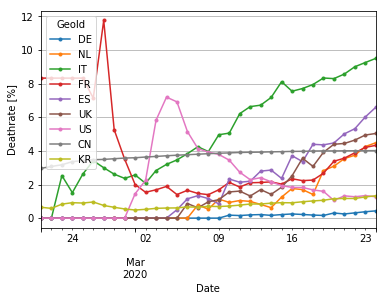

In [1087]:
Rdeath=Ndeaths[Interest]/Ncases[Interest]*100
p=Rdeath.plot(marker=".")
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("Deathrate [%]")
p.grid('on', which='major', axis='y')

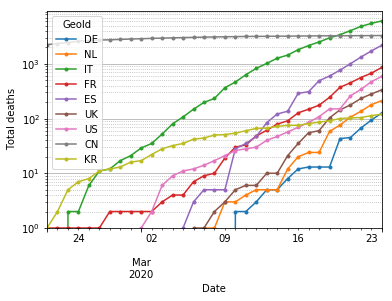

In [1088]:
p=Ndeaths[Interest].plot(logy=True, marker=".")
p.set_ylim(1,)
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("Total deaths")
p.grid('on', which='major', axis='y')
p.grid('on', which='minor', axis='y', linestyle='dotted')

Text(0,0.5,'doubling time [d]')

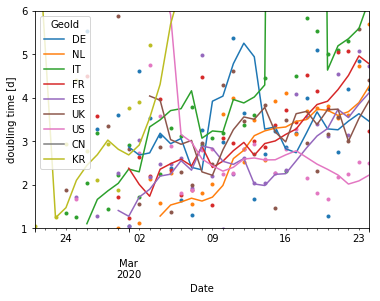

In [1089]:
p=Tdouble[Interest].plot(style=".", legend=False)
p.set_prop_cycle(None)
p=Tdouble_smooth[Interest].plot(ax=p)
p.set_ylim(1,6)
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("doubling time [d]")

Text(0.5,0,'time since case #100 [d]')

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


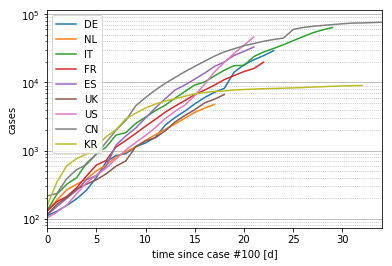

In [1090]:
p=Ncase100[Interest].plot(logy=True)
#p.legend(Countries.loc[Interest].values)
Days_IT=Ncase100.IT.index[Ncase100.IT==max(Ncase100.IT)].tolist().pop()
p.set_xlim([0,Days_IT+5])
p.grid('on', which='major', axis='y')
p.grid('on', which='minor', axis='y', linestyle='dotted')
p.set_ylabel("cases")
p.set_xlabel("time since case #100 [d]")

Text(0,0.5,'Deathrate [%]')

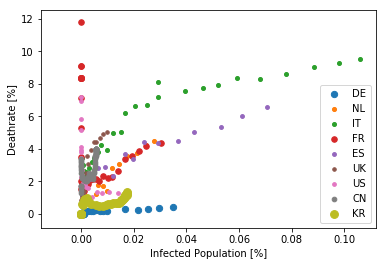

In [1104]:
for GeoId in Rinf:
    plt.scatter(Rinf[GeoId],Rdeath[GeoId], s=Hbeds[GeoId]/(Population[GeoId]*1000)*5, label=GeoId)
    
plt.legend()
plt.xlabel("Infected Population [%]")
plt.ylabel("Deathrate [%]")

In [1097]:
(Hbeds/(Population*1000)).dropna()

CN     4.342317
DE     7.894687
ES     2.962499
FR     6.125992
IT     3.184621
KR    12.288083
NL     3.319896
UK     2.468683
US     2.791842
dtype: float64